In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import os
from torch.autograd import Variable
import random
import numpy as np
import matplotlib.pyplot as plt
import model as VAE
%matplotlib inline

In [2]:
use_gpu = torch.cuda.is_available()
use_gpu

True

Data Preprocessing

In [3]:
f = []
root_path = './CVAE_2000_1000/'
training_data = []
DATA_LEN = 49
TRAIN_LEN = 7
for (dirpath, dirnames, filenames) in os.walk(root_path):
    f.extend(filenames)
for file in f:
    z = np.load(root_path + file)
    for len_num in range(z.shape[0] // TRAIN_LEN - 1):
        training_data.append(z[TRAIN_LEN*len_num : TRAIN_LEN*(len_num + 1)])
print(len(training_data))

122


(122, 7, 8, 28, 28)


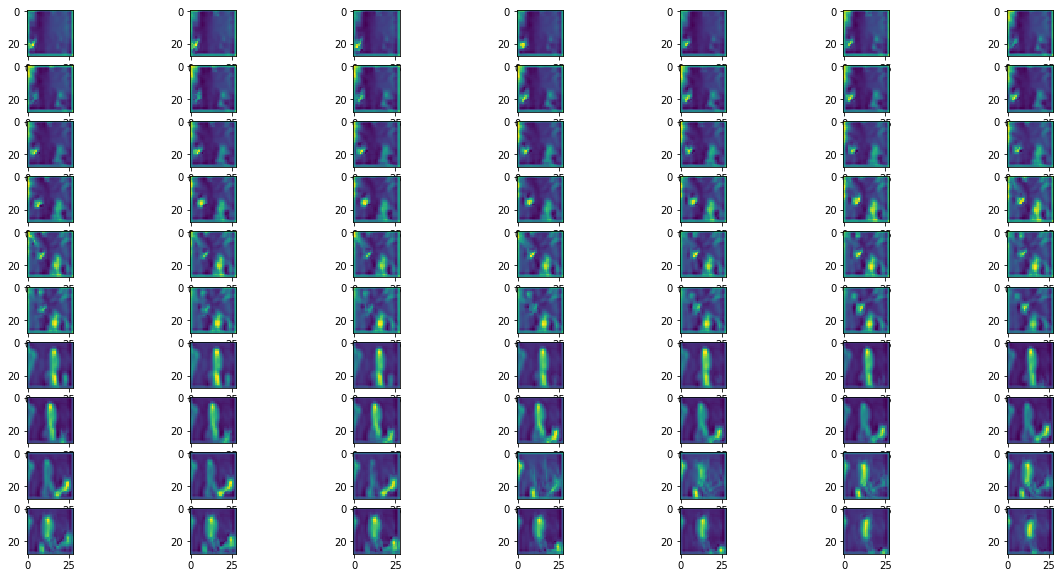

In [4]:
training_data = np.array(training_data)
print(training_data.shape)
f, axs = plt.subplots(10, 7, figsize=(20, 10))
for i, _ in enumerate(axs):
    for j, ax in enumerate(_):
        ax.imshow(training_data[i, j, 0])

In [5]:
training_data = training_data.reshape(training_data.shape[0], training_data.shape[1], -1)
training_data.shape

(122, 7, 6272)

In [6]:
print(training_data.max())
print(training_data.min())

11.329274
-6.763213


In [7]:
training_data = training_data/training_data.max()

Training

In [8]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.MSELoss()(recon_x, x)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return (BCE, KLD)

In [9]:
def train(data, model, optimizer, num_epochs=8, batch_size=25):
    KLD_list = []
    MSE_list = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        KLD_loss = 0
        MSE_loss = 0
        total_size = len(data)
        data = data[torch.randperm(len(data)).cuda()]
        model.train()
        for batch in range(total_size // batch_size):
            if (batch+1) * batch_size > len(data):
                break
            optimizer.zero_grad()
            current_data = data[batch * batch_size : (batch+1) * batch_size]
            out, mu, z = model(current_data)
            MSE, KLD = loss_function(out, current_data, mu, z)

            loss = MSE + KLD
#             loss = MSE
            loss.backward()
            optimizer.step()
            KLD_loss += KLD.data[0]
            MSE_loss += MSE.data[0]
        KLD_list.append(KLD_loss)
        MSE_list.append(MSE_loss)
        print('KLD loss: {}'.format(KLD_loss))
        print('MSE loss: {}'.format(MSE_loss))
    return model, KLD_list, MSE_list

In [10]:
model = VAE.LSTMVAE(seq_len=training_data.shape[1], input_dim=training_data.shape[2], batch_size=1)
if use_gpu:
    model.cuda()
optimizer = optim.Adam(model.parameters())

In [11]:
data = torch.FloatTensor(training_data)
if use_gpu:
    data = Variable(data).cuda()
else:
    data = Variable(data)
model, KLD, MSE = train(data, model, optimizer, num_epochs=100, batch_size=1)

Epoch 1/100
----------
KLD loss: 29.265437215566635
MSE loss: 0.053641850616259035
Epoch 2/100
----------
KLD loss: 20.650959827005863
MSE loss: 0.05253386628100998
Epoch 3/100
----------
KLD loss: 17.07873947173357
MSE loss: 0.052950457560655195
Epoch 4/100
----------
KLD loss: 15.229452162981033
MSE loss: 0.052285158075392246
Epoch 5/100
----------
KLD loss: 16.38780738413334
MSE loss: 0.05302761451457627
Epoch 6/100
----------
KLD loss: 12.300649471580982
MSE loss: 0.05271202683070442
Epoch 7/100
----------
KLD loss: 14.75324933975935
MSE loss: 0.05276059756579343
Epoch 8/100
----------
KLD loss: 13.12291793525219
MSE loss: 0.052426584785280284
Epoch 9/100
----------
KLD loss: 15.161969810724258
MSE loss: 0.05221708365570521
Epoch 10/100
----------
KLD loss: 10.306753687560558
MSE loss: 0.05264198326767655
Epoch 11/100
----------
KLD loss: 8.804400518536568
MSE loss: 0.052435042649449315
Epoch 12/100
----------
KLD loss: 9.649157971143723
MSE loss: 0.05233940346806776
Epoch 13/100
-

KLD loss: 0.043661147356033325
MSE loss: 0.051353906623262446


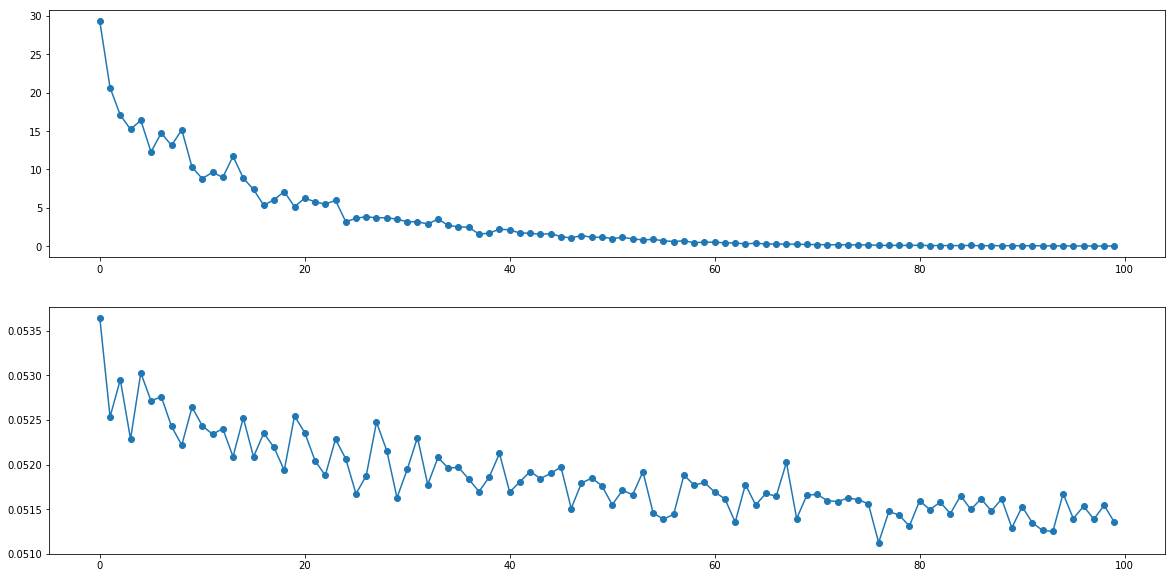

In [12]:
f, axs = plt.subplots(2, figsize=(20, 10))
axs[0].plot(range(100), KLD, linestyle='-', marker='o')
axs[1].plot(range(100), MSE, linestyle='-', marker='o')

In [13]:
model.eval()
mu, z = model.encoder(data[0].unsqueeze(0))
print(data[0])
print(z)

Variable containing:
-3.4990e-03 -4.6269e-03 -4.1501e-03  ...  -1.2208e-02 -9.8939e-03 -5.0284e-03
-3.1792e-03 -4.1313e-03 -3.6854e-03  ...  -1.2301e-02 -9.9264e-03 -5.0319e-03
-2.8745e-03 -3.6760e-03 -3.3156e-03  ...  -1.2373e-02 -9.9498e-03 -5.0296e-03
                ...                   ⋱                   ...                
-2.1515e-03 -2.8159e-03 -2.7853e-03  ...  -1.2516e-02 -1.0046e-02 -5.0499e-03
-1.7550e-03 -2.4273e-03 -2.6906e-03  ...  -1.2584e-02 -1.0113e-02 -5.0695e-03
-1.2128e-03 -1.9659e-03 -2.6035e-03  ...  -1.2636e-02 -1.0173e-02 -5.0808e-03
[torch.cuda.FloatTensor of size 7x6272 (GPU 0)]

Variable containing:
1.00000e-03 *
 -2.6376
[torch.cuda.FloatTensor of size 1x1 (GPU 0)]



In [14]:
recover = model.decoder(z)
recover.squeeze()

Variable containing:
-1.0187e-03 -6.5660e-04  1.2479e-03  ...  -8.4687e-04 -1.5017e-03  7.4660e-04
-9.5726e-04 -6.3453e-04  1.2404e-03  ...  -6.9901e-04 -1.4519e-03  7.4447e-04
-9.4473e-04 -6.2959e-04  1.2085e-03  ...  -6.7777e-04 -1.4399e-03  7.4666e-04
                ...                   ⋱                   ...                
-9.4046e-04 -6.2238e-04  1.1970e-03  ...  -6.6873e-04 -1.4339e-03  7.5169e-04
-9.4018e-04 -6.2167e-04  1.1965e-03  ...  -6.6750e-04 -1.4335e-03  7.5187e-04
-9.4015e-04 -6.2149e-04  1.1962e-03  ...  -6.6715e-04 -1.4334e-03  7.5190e-04
[torch.cuda.FloatTensor of size 7x6272 (GPU 0)]